### Random Forests at 14-days leadtime for all regions.

File generated 9/18/2025 for Chapter 4 of Dissertation. 
Modified 12/2/2025 for use in UFS analysis. 

This file utilizes definition statements containing RF architecture to create three separate RF models, each for a designated forecast region. 

Forecast leadtime can be changed as needed. 

In [1]:
##just to stop the excess number of warnings 
import warnings
warnings.filterwarnings('ignore')

#relevant import statements
import numpy as np
import math
import pandas as pd
import xarray as xr 
import pickle 
import matplotlib.pyplot as plt

import random
from random import seed
from random import randint
from random import sample

import seaborn as sns # statistical data visualization
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.feature_selection import SelectFromModel

import keras
import shap

2025-12-02 16:05:06.818396: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-02 16:05:06.862416: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-02 16:05:06.862440: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-02 16:05:06.863452: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-02 16:05:06.869956: I tensorflow/core/platform/cpu_feature_guar

In [2]:
#import definitions 
from SkillStats_MOD import BSS, RAS, PAS

from RF_archMOD import rf_featselect,rf_90thpercentile

I am going to do a modified version of the architecture def here because I have to change the dataset structure. 

Start with bringing in the old data for training/validation. 

In [3]:
#load OG input data, it is max/min standardized, NaNs removed
#stratospheric polar vortex ellipse diagnostics from Fernandez et al 2025 (in review)
infile = open("./old_data/nolag_extendedanom_input.p", 'rb') 
nolag_input = pickle.load(infile)
infile.close()

nolag_input.shape 

(62, 149, 8)

The input data stays the same regardless of forecast region. 

The original array starts on October 19th. The shift send this forward to November 2nd. 

In [4]:
idx = 135 #129 for 20, 119 for 30.
inp1 = np.empty((52,idx,7)) #cnew input array, 14 day lag. 
shift = 14

##reshaping to change lag in metrics for input
inp1[:,:,0] = nolag_input[:52,shift:,0] ##wind
inp1[:,:,1] = nolag_input[:52,shift:,1] ##ratio
inp1[:,:,2] = nolag_input[:52,shift:,2] ##latitude
inp1[:,:,3] = nolag_input[:52,shift:,3] ##longitude
inp1[:,:,4] = nolag_input[:52,shift:,4] ##size
inp1[:,:,5] = nolag_input[:52,shift:,5] ##ephi
inp1[:,:,6] = nolag_input[:52,shift:,6] ##gph

inp = inp1.reshape(52*idx,7)

#convert to pandas dataframe
input1 = pd.DataFrame(inp)
#label columns of variables for input data
col_names = ['wind','rat','cenlat','cenlon','size','ephi','gph']
input1.columns = col_names

In [5]:
##load in desired TESTING dataset... varies based on prototype.
infile = open("./new_data/input_ERA5.p", 'rb') 
testing_input = pickle.load(infile)
infile.close()

inp = testing_input.reshape(56*18,7)

#convert to pandas dataframe
input2 = pd.DataFrame(inp)
#label columns of variables for input data
col_names = ['wind','rat','cenlat','cenlon','size','ephi','gph']
input2.columns = col_names

### Begin RF Feature selection test. 

In [6]:
#number of cross validations
n = 100

In [ ]:
##Europe Feature Selection
eur_important = rf_featselect(n,shift,idx,input1,input2,'eur','Europe_Prototype8')

imp = np.nanmean(eur_important, axis = 0)
imp.shape

#plot features by relative importance
indices = np.argsort(imp)[::-1]  #sort by importance
c = ["navy","royalblue","slateblue","blueviolet","darkviolet","purple","mediumvioletred","magenta"]

plt.figure(figsize=(9, 6))
plt.title("Average Feature Importances Across 100 CVs, Europe +14",fontsize =18)
plt.barh(range(input1.shape[1]), imp[indices], align="center", color = c)
plt.yticks(range(input1.shape[1]), input1.columns[indices],fontsize =14)
plt.xticks(fontsize =14)
plt.xlabel("Relative Importance",fontsize =16)
plt.gca().invert_yaxis()
#plt.savefig("./images/EurRF_FeatureImportance_14days.png",bbox_inches = 'tight')

## Second RF run post feature selection

In [7]:
##change pandas dataframe to choose top 3 important features only
eur_input1 = input1[["wind","cenlon","cenlat","gph"]]
eur_input2 = input2[["wind","cenlon","cenlat","gph"]]

### Europe

In [8]:
##Europe Forecasts of opportunity
eur_test90, eur_fulltest, eur_shap_obj, eur_posXtest, eur_FposXtest, eur_negXtest, eur_FnegXtest = rf_90thpercentile(n,shift, idx, eur_input1, eur_input2, 'eur','Europe_Prototype8')

Check temp shape: (7020,)
Check climo shape: (7020, 2)
 
Creating lists ...
 
Establishing RF hyperparams ...
 
Begin RF CV.
 
END CV.
 
 
###################################################
Accuracy, Validation: 57.15%
Accuracy, Training: 62.08%
Accuracy, Testing: 51.29%
_____________________________________________________________________
Brier Skill Score (Train): 0.0723
Brier Skill Score (Test): -0.0283
Brier Skill Score (Validation): 0.0197
_____________________________________________________________________
Recall and Precision: Neg Cat
#########
Recall Accuracy Score (Train): 0.7581
Recall Accuracy Score (Test): 0.7191
Recall AccuracyScore (Validation): 0.7214
Precision Accuracy Score (Train): 0.6098
Precision Accuracy Score (Test): 0.5008
Precision AccuracyScore (Validation): 0.5666
_____________________________________________________________________
Recall and Precision: Pos Cat
#########
Recall Accuracy Score (Train): 0.4714
Recall Accuracy Score (Test): 0.3170
Recall Accur

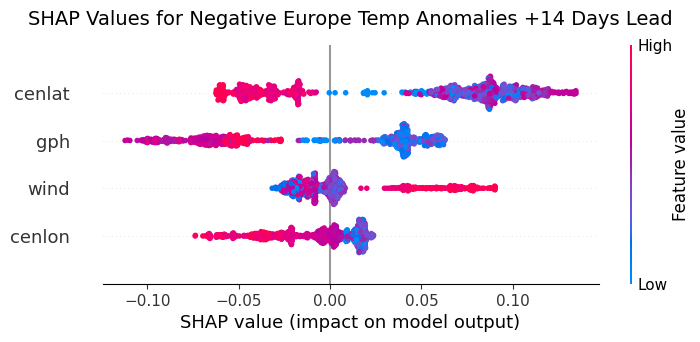

In [9]:
plt.title("SHAP Values for Negative Europe Temp Anomalies +14 Days Lead",fontsize =14, y = 1.05)
ax = shap.plots.beeswarm(eur_shap_obj[:,:,0], show = False) ##for negative classifications ... this is physically consistent!
#plt.savefig("./images/SHAPEur_14days.png",bbox_inches = 'tight')

Text(0.5, 1.0, 'Testing Prediction ACC Across 100 RF Models, Europe +14')

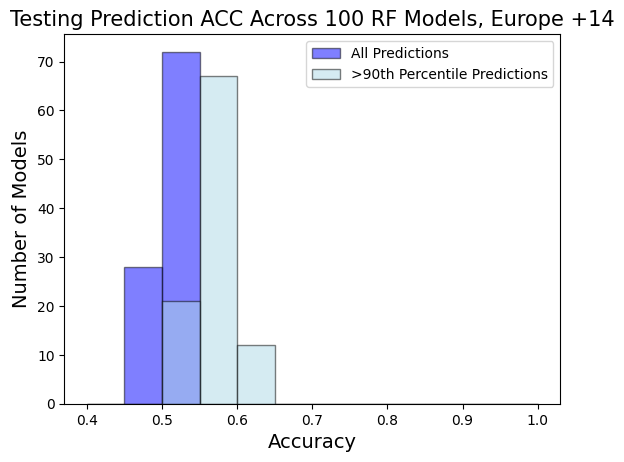

In [10]:
#######bar plot for showing the distribution of confident predictions
bins = np.linspace(0.4, 1,13)  # 10 bins from 0.4 to 1
##bin the testing 90th percentile accuracy data
counts90, edges90 = np.histogram(eur_test90, bins=bins)
countsfull, edgesfull = np.histogram(eur_fulltest, bins=bins)
#plot the full dataset
#offset = 0.02  # Adjust this value if needed for better visibility
plt.bar(edgesfull[:-1], countsfull, width=np.diff(edgesfull), 
        edgecolor='black', alpha=0.5, label='All Predictions', align='edge', color='blue')

#plot the 90th percentile
plt.bar(edges90[:-1], counts90, width=np.diff(edges90), 
        edgecolor='black', alpha=0.5, label='>90th Percentile Predictions', align='edge', color = 'lightblue')
plt.xlabel('Accuracy',fontsize =14)
plt.ylabel('Number of Models',fontsize =14)
plt.legend()
plt.title('Testing Prediction ACC Across 100 RF Models, Europe +14',fontsize =15)
#plt.savefig("./images/Eur14_ACC.png",bbox_inches = 'tight')